### a. Définition des caractéristiques de la poutre et des conditions aux limites

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Caractéristiques géométriques et matérielles
L = 10.0  # Longueur de la poutre en mètres
A = 0.01  # Section transversale en mètres carrés
E = 210e9  # Module de Young en Pascals
I = 8.1e-6  # Moment d'inertie en mètres à la puissance quatre

# Discrétisation de la poutre en éléments finis
n = 10  # Nombre d'éléments
node_count = n + 1  # Nombre de nœuds
element_length = L / n  # Longueur de chaque élément

# Conditions aux limites et charges
fixed_nodes = [0]  # Encastrement au nœud 0
load_node = n  # Charge appliquée au nœud n
load_value = -10000  # Valeur de la charge en Newtons


### b. Formation de la matrice de rigidité élémentaire et assemblage de la matrice de rigidité globale

In [11]:
# Fonction pour calculer la matrice de rigidité élémentaire
def element_stiffness_matrix(E, I, L):
    k = (E * I / L**3) * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    return k

# Initialisation de la matrice de rigidité globale
global_stiffness_matrix = np.zeros((2*node_count, 2*node_count))

# Assemblage de la matrice de rigidité globale
for i in range(n):
    ke = element_stiffness_matrix(E, I, element_length)
    global_stiffness_matrix[2*i:2*i+4, 2*i:2*i+4] += ke

### c. Application des conditions aux limites

In [12]:
# Application des conditions aux limites (encastrement au nœud 0)
for node in fixed_nodes:
    global_stiffness_matrix[2*node, :] = 0
    global_stiffness_matrix[:, 2*node] = 0
    global_stiffness_matrix[2*node+1, :] = 0
    global_stiffness_matrix[:, 2*node+1] = 0
    global_stiffness_matrix[2*node, 2*node] = 1
    global_stiffness_matrix[2*node+1, 2*node+1] = 1

### d. Résolution du système d'équations pour obtenir les déplacements nodaux

In [13]:
# Vecteur des forces
force_vector = np.zeros(2*node_count)
force_vector[2*load_node+1] = load_value

# Résolution du système d'équations
displacements = np.linalg.solve(global_stiffness_matrix, force_vector)

### e. Calcul des contraintes et déformations et des moments, forces normales et forces tranchantes

In [14]:
# Calcul des déformations et contraintes
def calculate_strain_displacement(element_displacements, L):
    return (element_displacements[1] - element_displacements[0]) / L

def calculate_stress(strain, E):
    return strain * E

strains = np.zeros(n)
stresses = np.zeros(n)
for i in range(n):
    u = displacements[2*i:2*i+2]  # Prendre les déplacements nodaux pour l'élément
    strains[i] = calculate_strain_displacement(u, element_length)
    stresses[i] = calculate_stress(strains[i], E)

In [16]:
def calculate_moments(displacements, E, I, L):
    moments = np.zeros(n)
    for i in range(n):
        u = displacements[2*i:2*i+4]
        moments[i] = E * I * (u[2] - 2*u[1] + u[0]) / (L**2)
    return moments

def calculate_normal_forces(displacements, E, A, L):
    normal_forces = np.zeros(n)
    for i in range(n):
        u = displacements[2*i:2*i+4]
        normal_forces[i] = E * A * (u[2] - u[0]) / L
    return normal_forces

def calculate_shear_forces(moments, L):
    shear_forces = np.zeros(n)
    for i in range(1, n):
        shear_forces[i] = (moments[i] - moments[i-1]) / L
    return shear_forces


In [17]:
# Calcul des moments, forces normales et forces tranchantes
moments = calculate_moments(displacements, E, I, element_length)
normal_forces = calculate_normal_forces(displacements, E, A, element_length)
shear_forces = calculate_shear_forces(moments, element_length)

### f. Visualisation des résultats

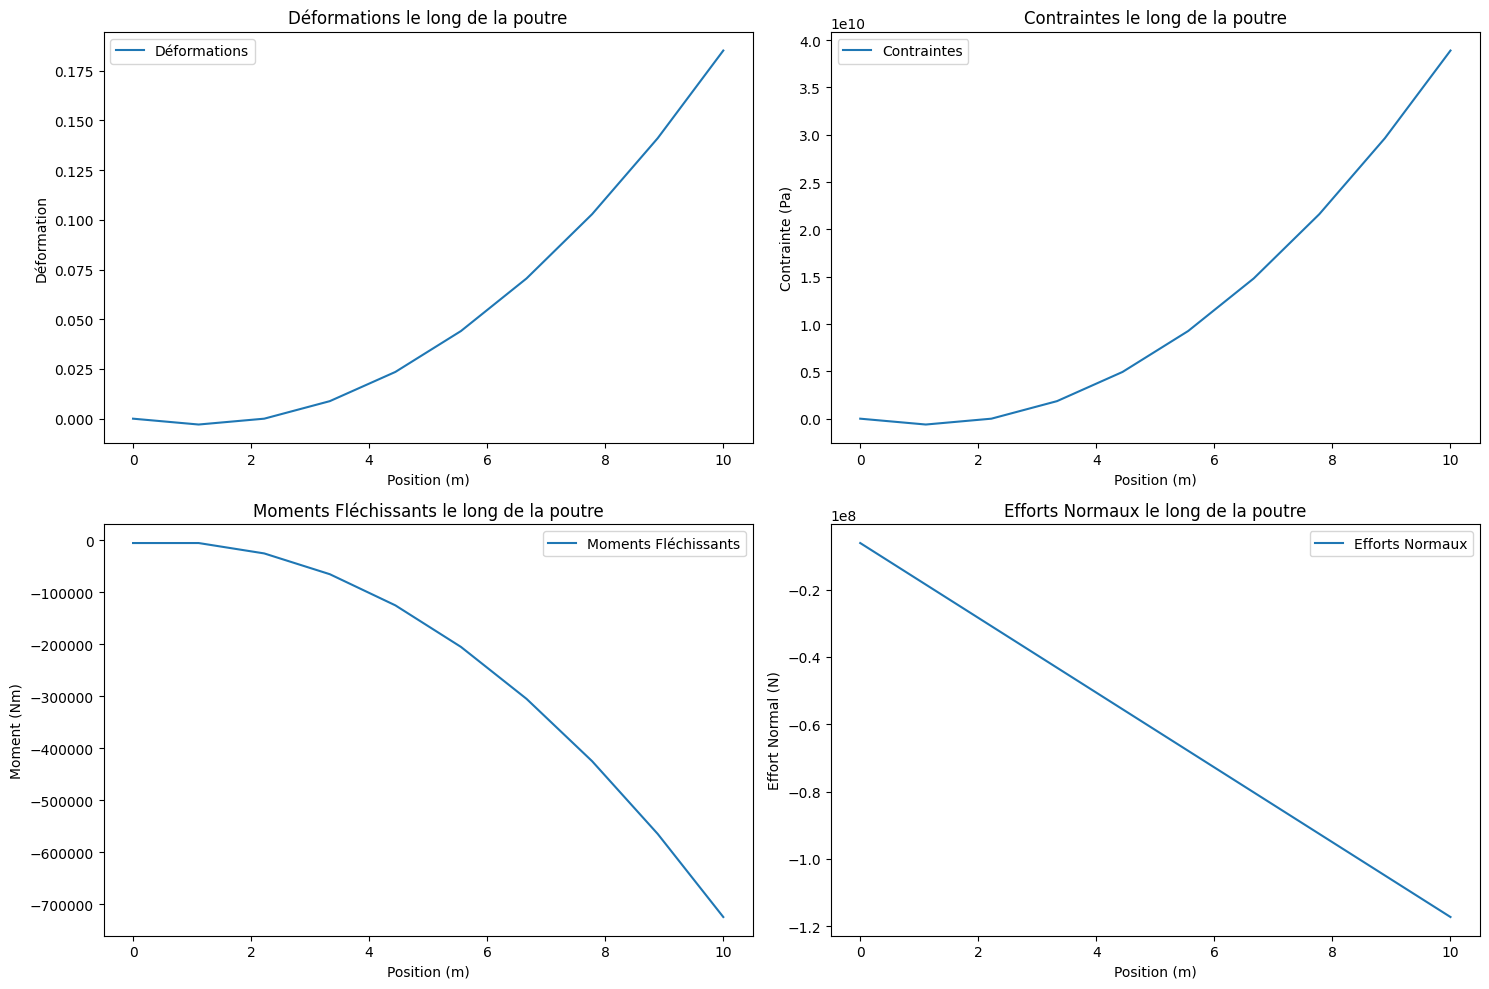

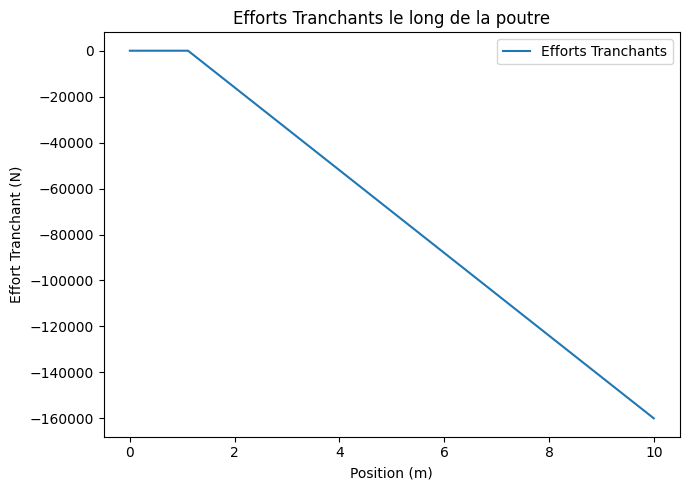

In [18]:
# Visualisation des résultats
x = np.linspace(0, L, n)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(x, strains, label='Déformations')
plt.xlabel('Position (m)')
plt.ylabel('Déformation')
plt.title('Déformations le long de la poutre')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x, stresses, label='Contraintes')
plt.xlabel('Position (m)')
plt.ylabel('Contrainte (Pa)')
plt.title('Contraintes le long de la poutre')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, moments, label='Moments Fléchissants')
plt.xlabel('Position (m)')
plt.ylabel('Moment (Nm)')
plt.title('Moments Fléchissants le long de la poutre')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x, normal_forces, label='Efforts Normaux')
plt.xlabel('Position (m)')
plt.ylabel('Effort Normal (N)')
plt.title('Efforts Normaux le long de la poutre')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(x, shear_forces, label='Efforts Tranchants')
plt.xlabel('Position (m)')
plt.ylabel('Effort Tranchant (N)')
plt.title('Efforts Tranchants le long de la poutre')
plt.legend()

plt.tight_layout()
plt.show()